This script will compare the image compositing methods in north america

Read in packages

In [7]:
import pandas as pd
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.lib.io import file_io
from tensorflow.python.keras.optimizer_v2.adam import Adam
import segmentation_models as sm
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras_unet_collection import models
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
# import tensorflow_addons as tfa
# from tensorflow import tensorflow.keras.mixed_precision.set_global_policy("mixed_float16")

Read in the testing data for all four models, plus all the mtbs data for models 1 and 2

In [2]:
#old
testing_names = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/mtbs_testing_files.csv')['Files'].tolist()
testing_names2 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/nbac_testing_files.csv')['Files'].tolist()

testing_names_old = testing_names + testing_names2

#monthly 
testing_names = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/mtbs_85_testing_files.csv')['Files'].tolist()
testing_names2 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_85_testing_files.csv')['Files'].tolist()

testing_names_monthly = testing_names + testing_names2





Set up image generator for dnbr


Image generator for 3 bands

In [8]:
min_max_vi = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_global_min_max_cutoff_proj.csv").reset_index(drop = True)
min_max_vi = min_max_vi[['6', '7', '8']]



class img_gen_vi(tensorflow.keras.utils.Sequence):

    """Helper to iterate over the data (as Numpy arrays).
    Inputs are batch size, the image size, the input paths (x) and target paths (y)
    """

    #will need pre defined variables batch_size, img_size, input_img_paths and target_img_paths
    def __init__(self, batch_size, img_size, input_img_paths):
	    self.batch_size = batch_size
	    self.img_size = img_size
	    self.input_img_paths = input_img_paths
	    self.target_img_paths = input_img_paths

    #number of batches the generator is supposed to produceis the length of the paths divided by the batch siize
    def __len__(self):
	    return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_img_paths = self.input_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (x)
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (y)
		
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32") #create matrix of zeros which will have the dimension height, wideth, n_bands), 8 is the n_bands
        
  
         #start populating x by enumerating over the input img paths
        for j, path in enumerate(batch_img_paths):

            #load image
            img =  np.round(np.load(path), 3)[:, :, 6:9]

            # img = img * 1000
            img = img.astype(float)
            img = np.round(img, 3)
            img[img == 0] = -999

            img[np.isnan(img)] = -999


            img[img == -999] = np.nan

            in_shape = img.shape
            
            #turn to dataframe to normalize
            img = img.reshape(img.shape[0] * img.shape[1], img.shape[2])
			
            img = pd.DataFrame(img)
			
            img.columns = min_max_vi.columns
			
            img = pd.concat([min_max_vi, img]).reset_index(drop = True)


            #normalize 0 to 1
            img = pd.DataFrame(scaler.fit_transform(img))
			
            img = img.iloc[2:]
#
#             img = img.values.reshape(in_shape)
            img = img.values.reshape(in_shape)

#             replace nan with -1
            img[np.isnan(img)] = -1

#apply standardization
# img = normalize(img, axis=(0,1))

            img = np.round(img, 3)
            #populate x
            x[j] = img#[:, :, 4:] index number is not included, 


        #do tthe same thing for y
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")

        for j, path in enumerate(batch_target_img_paths):

            #load image
            img =  np.round(np.load(path), 3)[:, :, -1]

            img = img.astype(int)

            img[img < 0] = 0
            img[img >1] = 0
            img[~np.isin(img, [0,1])] = 0

            img[np.isnan(img)] = 0
            img = img.astype(int)

            # img =  tf.keras.utils.to_categorical(img, num_classes = 2)
            # y[j] = np.expand_dims(img, 2) 
            y[j] = img
  
       
    #Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
    # y[j] -= 1

        return x, y


In [16]:
min_max = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_global_min_max_cutoff_proj.csv").reset_index(drop = True)

min_max = min_max[['6', '7', '8']]

class img_gen_vi_monthly(tensorflow.keras.utils.Sequence):

    """Helper to iterate over the data (as Numpy arrays).
    Inputs are batch size, the image size, the input paths (x) and target paths (y)
    """

    #will need pre defined variables batch_size, img_size, input_img_paths and target_img_paths
    def __init__(self, batch_size, img_size, input_img_paths):
	    self.batch_size = batch_size
	    self.img_size = img_size
	    self.input_img_paths = input_img_paths
	    self.target_img_paths = input_img_paths

    #number of batches the generator is supposed to produceis the length of the paths divided by the batch siize
    def __len__(self):
	    return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_img_paths = self.input_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (x)
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (y)
		
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32") #create matrix of zeros which will have the dimension height, wideth, n_bands), 8 is the n_bands
        
  
         #start populating x by enumerating over the input img paths
        for j, path in enumerate(batch_img_paths):

            #load image
            img =  np.round(np.load(path), 3)[:, :, :-1]

            # img = img * 1000
            img = img.astype(float)
            img = np.round(img, 3)
            img[img == 0] = -999

            img[np.isnan(img)] = -999


            img[img == -999] = np.nan

            in_shape = img.shape
            
            #turn to dataframe to normalize
            img = img.reshape(img.shape[0] * img.shape[1], img.shape[2])
			
            img = pd.DataFrame(img)
			
            img.columns = min_max.columns
			
            img = pd.concat([min_max, img]).reset_index(drop = True)


            #normalize 0 to 1
            img = pd.DataFrame(scaler.fit_transform(img))
			
            img = img.iloc[2:]
#
#             img = img.values.reshape(in_shape)
            img = img.values.reshape(in_shape)

#             replace nan with -1
            img[np.isnan(img)] = -1

#apply standardization
# img = normalize(img, axis=(0,1))

            img = np.round(img, 3)
            #populate x
            x[j] = img#[:, :, 4:] index number is not included, 


        #do tthe same thing for y
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")

        for j, path in enumerate(batch_target_img_paths):

            #load image
            img =  np.round(np.load(path), 3)[:, :, -1]

            img = img.astype(int)

            img[img < 0] = 0
            img[img >1] = 0
            img[~np.isin(img, [0,1])] = 0

            img[np.isnan(img)] = 0
            img = img.astype(int)

            # img =  tf.keras.utils.to_categorical(img, num_classes = 2)
            # y[j] = np.expand_dims(img, 2) 
            y[j] = img
  
       
    #Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
    # y[j] -= 1

        return x, y

Read in the images based on the generator

In [17]:
#batch size and img size
BATCH_SIZE = 45
GPUS = ["GPU:0", "GPU:1", "GPU:2", "GPU:3"]
strategy = tensorflow.distribute.MirroredStrategy() #can add GPUS here to select specific ones
print('Number of devices: %d' % strategy.num_replicas_in_sync) 

batch_size = BATCH_SIZE * strategy.num_replicas_in_sync

#image size
img_size = (128, 128)

#number of classes to predict
num_classes = 1

#old compsoitie gen
models_vi_gen_old =  img_gen_vi(batch_size, img_size, testing_names_old)

#new composite gen
mtbs_vi_gen_monthly =  img_gen_vi_monthly(batch_size, img_size, testing_names_monthly)



Number of devices: 1


Read in all the models

In [5]:
#old
model_1 = tensorflow.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/models/nbac_mtbs_regularize_50_global_norm.tf", 
                                           custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
                                                           'recall':sm.metrics.Recall(threshold = 0.5),
                                                            'f1-score': sm.metrics.FScore(threshold=0.5),
                                                             'iou_score': sm.metrics.IOUScore(threshold=0.5),
                                                              'accuracy': 'accuracy'})
#monthly
model_2 = tensorflow.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/models/nbac_mtbs_regularize_50_global_norm_85.tf", 
                                           custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
                                                           'recall':sm.metrics.Recall(threshold = 0.5),
                                                            'f1-score': sm.metrics.FScore(threshold=0.5),
                                                             'iou_score': sm.metrics.IOUScore(threshold=0.5)})





Model 1 testing scores

In [9]:
model_1_res = model_1.evaluate_generator(models_vi_gen_old, 100)

iou = model_1_res[-2]
precision = model_1_res[-5]
recall = model_1_res[-4]
f1 = model_1_res[-3]
accuracy = model_1_res[-1]

print(f"Model 1 testing IoU is {iou}")
print(f"Model 1 testing precision is {precision}")
print(f"Model 1 testing recall is {recall}")
print(f"Model 1 testing f1 is {f1}")
print(f"Model 1 testing accuracy is {accuracy}")


/tmp/ipykernel_2399742/1357367513.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_1_res = model_1.evaluate_generator(models_vi_gen_old, 100)


Model 1 testing IoU is 0.845574140548706
Model 1 testing precision is 0.9074278473854065
Model 1 testing recall is 0.9259670376777649
Model 1 testing f1 is 0.9157931804656982
Model 1 testing accuracy is 0.9665975570678711


Model 2 testing scores

In [18]:
model_2_res = model_2.evaluate_generator(mtbs_vi_gen_monthly, 100)

iou = model_2_res[-2]
precision = model_2_res[-5]
recall = model_2_res[-4]
f1 = model_2_res[-3]
accuracy = model_2_res[-1]

print(f"Model 2 testing IoU is {iou}")
print(f"Model 2 testing precision is {precision}")
print(f"Model 2 testing recall is {recall}")
print(f"Model 2 testing f1 is {f1}")
print(f"Model 2 testing accuracy is {accuracy}")

/tmp/ipykernel_2399742/3995836273.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_2_res = model_2.evaluate_generator(mtbs_vi_gen_monthly, 100)


Model 2 testing IoU is 0.8408824801445007
Model 2 testing precision is 0.9428690075874329
Model 2 testing recall is 0.8868805170059204
Model 2 testing f1 is 0.9118126630783081
Model 2 testing accuracy is 0.9785333275794983


Model 3 testing scores

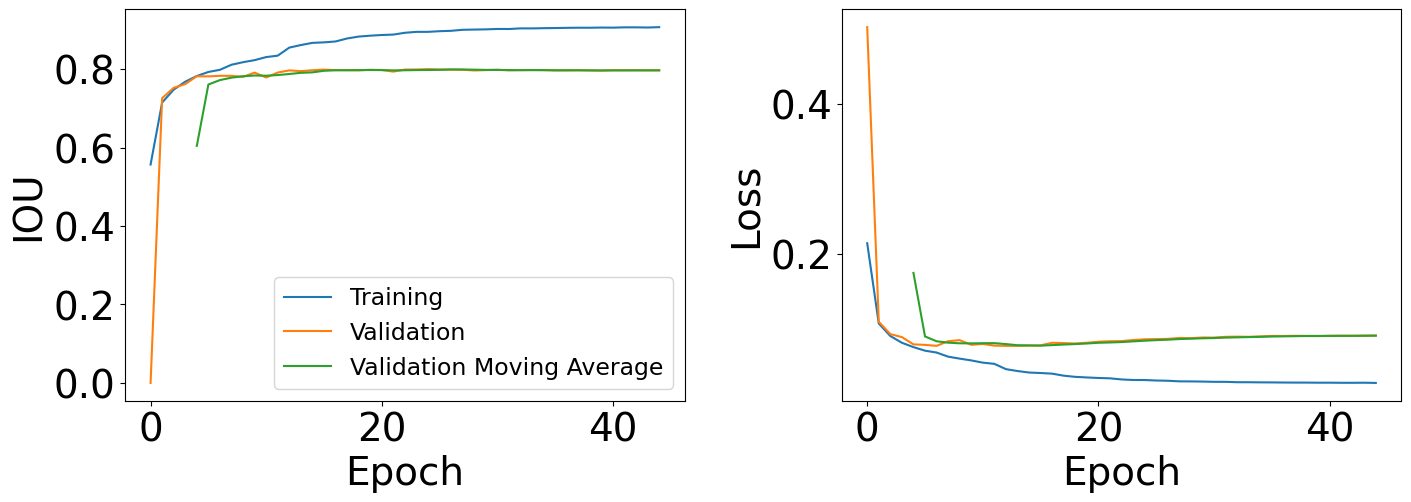

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os

font = {'family' : 'normal',
        'size'   : 28}

# df = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/modis_dnbr_0_five_plus_128_2d_ds_aug.csv")
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_proj.csv')

# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_proj_final.csv')

#good models
df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_VI_one_128_2d_ds_proj_final_mtbs.csv').head(48)
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_proj_final.csv')
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_proj_mtbs.csv')
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_VI_one_128_2d_ds_proj_final.csv')
df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_mtbs_swin_no_reg_glob_norm.csv')
df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_mtbs_no_regularize_50_global_norm.csv')
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_mtbs_regularize_50_global_norm.csv')
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_mtbs_regularize_50_global_norm_85.csv')
df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_mtbs_modis_16_global_norm.csv')

df['Moving Average'] = df['Val_IOU'].rolling(5).mean()
df['Moving Average2'] = df['Val_Loss'].rolling(5).mean()

#good models

# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_global_min_max_cutoff_proj_mtbs.csv')
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_long_neg.csv')
#l8_sent_collection2_crop_dnbr_0_two_long_128.csv
#l8_sent_collection2_crop_dnbr_0_two_long_128_neg_aug.csv
matplotlib.rc('font', **font)

#plot the curves
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(df['IOU'])
plt.plot(df['Val_IOU'])
plt.plot(df['Moving Average'])

# plt.title("Model IoU")
plt.ylabel('IOU')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
# plt.xlim(40,70)
plt.legend(['Training', 'Validation', 'Validation Moving Average'], loc='lower right', prop={'size': 17})


# Plot training & validation loss values
plt.subplot(222)
plt.plot(df['Loss'])
plt.plot(df['Val_Loss'])
plt.plot(df['Moving Average2'])

# plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.text(0.01, 0.00, 'Epoch', ha='center')


# plt.subplot(223)
# plt.plot(df['F1'])
# plt.plot(df['Val_F1'])
# plt.title('Model F1')
# plt.ylabel('F1')
# plt.xlabel('Epoch')
# plt.ylim(0, 1)
plt.tight_layout()

out_path = "/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/figures"
if not os.path.isdir(out_path):
    os.makedirs(out_path)

# plt.savefig(os.path.join(out_path, 'mtbs_nbac_VI_curve_adaptive.png'), dpi = 200, bbox_inches = 'tight') #17 epochs

# plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# plt.subplot(122)
# plt.plot(df['Loss'])
# plt.plot(df['Val_Loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.ylim(0, 1)
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()